In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import shap

In [2]:
# Load the data
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv', usecols=['userId', 'movieId', 'rating'])
tags = pd.read_csv('ml-latest-small/tags.csv', usecols=['userId', 'movieId', 'tag'])
links = pd.read_csv('ml-latest-small/links.csv')

In [3]:
# Prepare the data
# Group tags by userId and movieId, combining tags for each movie by each user
g = {i: lambda x: '|'.join(list(x)) for i in tags.columns[2:]}
tags = tags.groupby(['userId', 'movieId']).agg(g).reset_index()

In [4]:
# Merge movies with links, and merge reviews (ratings + tags) with movies
movies = pd.merge(movies, links, on=['movieId'])
reviews = pd.merge(ratings, tags, on=['userId', 'movieId'])
reviews = pd.merge(reviews, movies[['movieId', 'genres']], on='movieId')

In [5]:
# Display frist 5 rows
print("Movies head:\n", movies.head())
print("Reviews head:\n", reviews.head())

Movies head:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  imdbId   tmdbId  
0  Adventure|Animation|Children|Comedy|Fantasy  114709    862.0  
1                   Adventure|Children|Fantasy  113497   8844.0  
2                               Comedy|Romance  113228  15602.0  
3                         Comedy|Drama|Romance  114885  31357.0  
4                                       Comedy  113041  11862.0  
Reviews head:
    userId  movieId  rating                                      tag  \
0       2    60756     5.0       funny|Highly quotable|will ferrell   
1       2    89774     5.0               Boxing story|MMA|Tom Hardy   
2       2   106782     5.0  drugs|Leonardo DiCaprio|Martin Sc

In [6]:
# Display data information
movies_info = (movies.shape[1], movies.shape[0])
ratings_info = (ratings.shape[1], ratings.shape[0])
tags_info = (tags.shape[1], tags.shape[0])
links_info = (links.shape[1], links.shape[0])
print(f"Movies: {movies_info[1]} records, {movies_info[0]} attributes")
print(f"Ratings: {ratings_info[1]} records, {ratings_info[0]} attributes")
print(f"Tags: {tags_info[1]} records, {tags_info[0]} attributes")
print(f"Links: {links_info[1]} records, {links_info[0]} attributes")

Movies: 9742 records, 5 attributes
Ratings: 100836 records, 3 attributes
Tags: 1775 records, 3 attributes
Links: 9742 records, 3 attributes


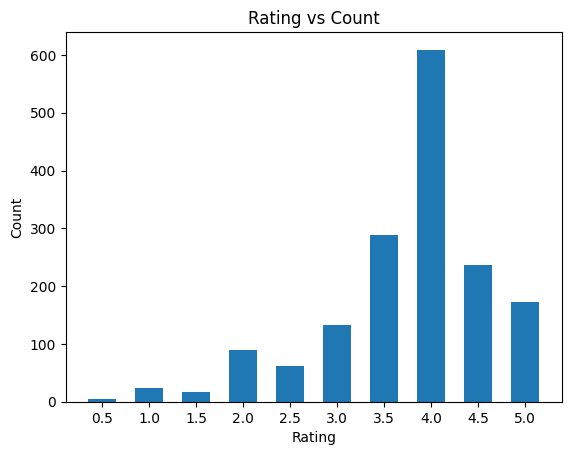

In [7]:
# Visualize rating distribution
ratings_df = reviews.groupby(by=['rating']).agg({'userId': 'count'}).rename(columns={'userId': 'count'}).reset_index()
plt.bar(ratings_df['rating'], ratings_df['count'], align='center', width=0.3)
plt.xticks(ratings_df['rating'])
plt.title("Rating vs Count")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [8]:
display(movies)

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0
9739,193585,Flint (2017),Drama,6397426,479308.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0


In [9]:
# Vectorize tags
tag_vectorizer = TfidfVectorizer()
tag_matrix = tag_vectorizer.fit_transform(reviews['tag'].fillna(''))

# Vectorize movie genres
genre_vectorizer = TfidfVectorizer()
genre_matrix = genre_vectorizer.fit_transform(reviews['genres'].fillna(''))

# Combine tag and genre vectors
X = hstack([tag_matrix, genre_matrix])

# Prepare the target variable
y = reviews['rating']

In [10]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define models
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(),
    'LinearRegression': LinearRegression(),
    'NeuralNetwork': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

In [12]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}
    print(f'{name} - MSE: {mse}, R²: {r2}')

DecisionTree - MSE: 1.129459734964322, R²: -0.7225950463910542
RandomForest - MSE: 0.6870793665068009, R²: -0.047898810894312804
GradientBoosting - MSE: 0.6444699206157112, R²: 0.017086967836238753
LinearRegression - MSE: 0.964792800277097, R²: -0.47145333924062327
NeuralNetwork - MSE: 0.8876487945552585, R²: -0.35379719090577355


In [13]:
# Select the best model
model = models['GradientBoosting']

In [14]:
# Predict ratings on the test set
y_test_pred = model.predict(X_test)

In [15]:
# Compare predicted ratings with actual ratings
results_df = pd.DataFrame({'Actual Rating': y_test, 'Predicted Rating': y_test_pred})
print(results_df.head(10))

      Actual Rating  Predicted Rating
937             4.5          3.862634
1097            4.5          3.862634
813             4.0          3.832516
607             4.5          3.862634
1304            4.0          3.372133
1074            4.0          3.862634
839             4.0          3.808982
809             4.5          3.808982
1237            4.0          3.808982
271             3.5          3.862634


In [16]:
# Calculate test metrics
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'Test MSE: {mse_test}')
print(f'Test R²: {r2_test}')

Test MSE: 0.6444699206157112
Test R²: 0.017086967836238753


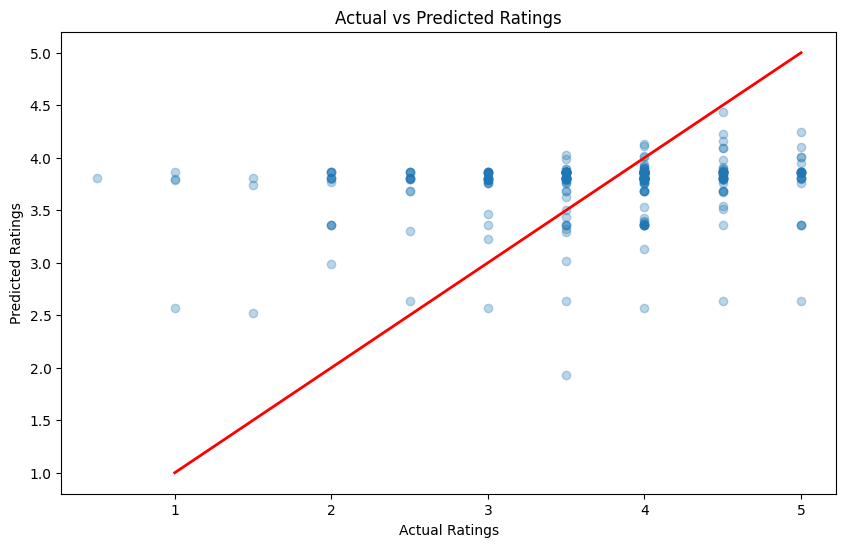

In [17]:
# Plot actual vs predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.plot([1, 5], [1, 5], color='red', linewidth=2)  # Ideal line (y=x)
plt.show()

In [18]:
# Convert sparse matrix to dense matrix
X_test_dense = X_test.toarray()

In [19]:
# Analyze feature importance using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_dense, check_additivity=False)


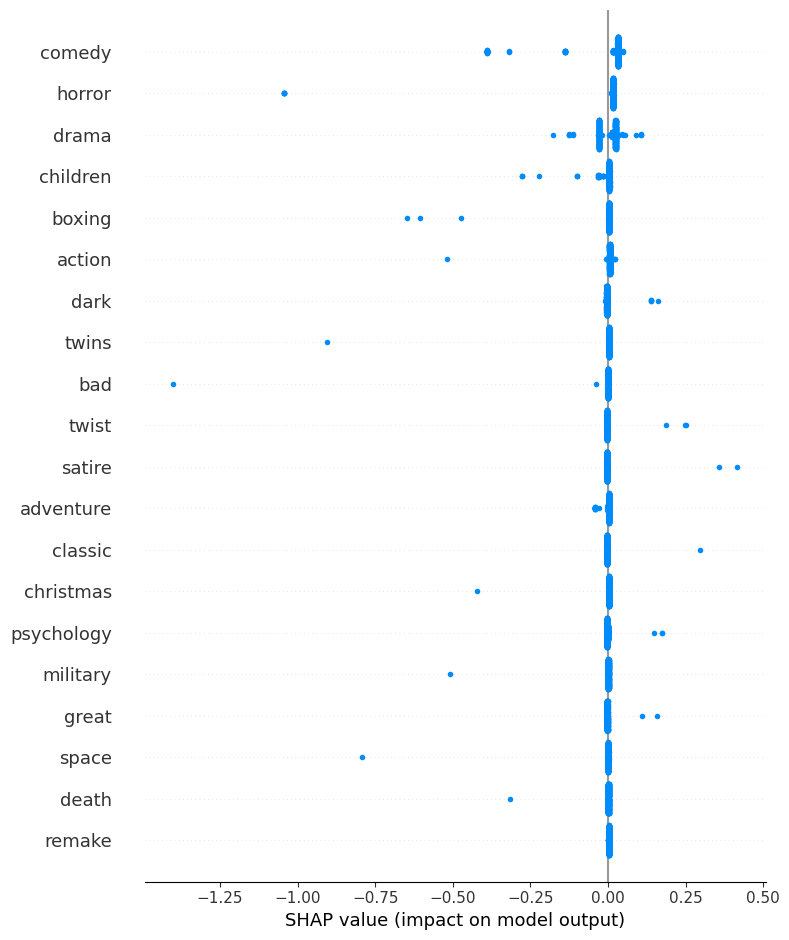

In [20]:
# Combine feature names from tag and genre vectorizers
all_feature_names = np.concatenate((tag_vectorizer.get_feature_names_out(), genre_vectorizer.get_feature_names_out()))
shap.summary_plot(shap_values, feature_names=all_feature_names)

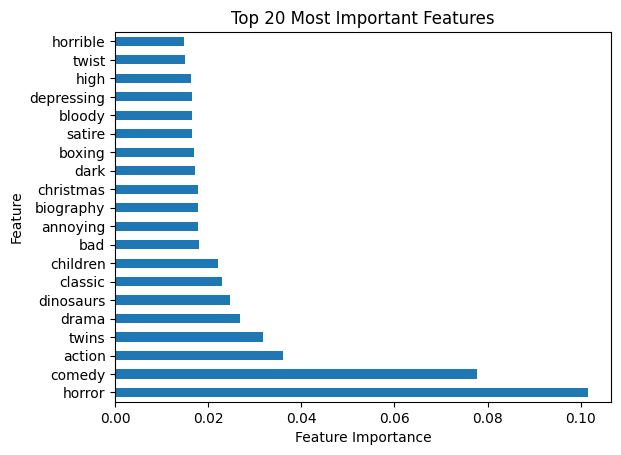

In [21]:
# Plot the top 20 most important features
feature_importances = pd.Series(model.feature_importances_, index=all_feature_names)
feature_importances.nlargest(20).plot(kind='barh')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()